# Find correction coefficients for input file 
### (simplified version of make_NIRCam_linearity_reffile.py)

In [1]:
# import modules
import warnings
import yaml
import itertools
from astropy.io import fits
from astropy.stats import sigma_clip
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
from matplotlib import pyplot as plt
from matplotlib import rc,rcParams
from matplotlib.pyplot import cm 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
#import seaborn as sns
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format='retina'

rc('text', usetex=True)
rc('font', family='New Century Schoolbook')
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20)
rcParams['xtick.major.pad'] = 10
rcParams['ytick.major.pad'] = 10

In [3]:
# define function to use

def init_arrays(num_coefs, coords):
    '''Initialize arrays to collect output from steps.'''
    
    slope_int_arr = np.zeros((2, coords[3], coords[2]))
    coeffs_arr = np.zeros((num_coefs, coords[3], coords[2]))
    dq_arr = np.zeros((coords[3], coords[2]))
    sat_arr = np.zeros((4, coords[3], coords[2]))
    mask_arr = np.zeros(np.shape(coeffs_arr), dtype='bool')

    return coeffs_arr, dq_arr, sat_arr, mask_arr, slope_int_arr


def load_data(data):
    '''Load the data and define variables for other functions to use.'''

    with fits.open(data) as fil:
        hdr = fil[0].header
        data = fil[1].data
        tgroup = hdr['TGROUP']
        ngroups = hdr['NGROUP']
        skip = hdr['DRPFRMS3']
        nframe = hdr['NFRAME']

    return data, hdr, tgroup, ngroups, skip, nframe


def get_saturation(signal, sigma_range, limit):
    '''Find hard saturation for each ramp.'''

    # Determine saturation by making array of signal differences between
    # consecutive frames. Signal differences after saturation will be
    # close to zero.
    sig_diff = np.diff(signal)

    # Choose 3-sigma region around mean of zero to find saturation limit.
    three_sigma = limit * np.std(sig_diff[sigma_range[0]:sigma_range[1]])
    upperbound = three_sigma
    lowerbound = -1 * three_sigma
    first_sat_grp = np.argmax((lowerbound < sig_diff) &
                              (sig_diff < upperbound))

    # Hard saturation limit = average signal level of saturated frames.
    hard_sat = np.average(signal[first_sat_grp:])

    print("In get_saturation:")
    print(limit,np.std(sig_diff[sigma_range[0]:sigma_range[1]]),upperbound,lowerbound)
    print(sig_diff[20:25])
    print(sig_diff[-10:])
    
    return hard_sat, first_sat_grp


def ramp_fit(pixel, first_frame, tgroup, ramp, poly_order, unc_ron):
    '''Function to fit the ramp and determine ideal linear signal.'''

    # Define minimum frame to include in ramp fitting (either 0 or 1, 0
    # gives a larger bias value). Make sure arrays are floats.
    frame_cut = ramp[0][first_frame:]
    new_ramp = [np.asfarray(frame_cut*tgroup),
                np.asfarray(ramp[1][first_frame:])]

    # Define polynomial function of the true signal rate for different
    # polynomial orders. Here, 'b' will be constant signal rate for
    # perfect detector and 'c', 'd', 'e', etc. describe magnitudes of
    # deviations from ideal signal.
    if poly_order == 5:
        def func(t, a, b, c, d, e, f):
            bt = b*t
            # Using Horner's method to optimize speed, so this polynomial:
            # a+ bt+ c*(bt)**2+ d*(bt)**3+ e*(bt)**4+ f*(bt)**5
            # becomes:
            return a + bt*(1 + bt*(c + bt*(d + bt*(e + bt*f))))

    elif poly_order == 4:
        def func(t, a, b, c, d, e):
            bt = b*t
            return a + bt*(1 + bt*(c + bt*(d + bt*e)))

    else:
        print('Ramp fit polynomial order not available. Quitting.')
        sys.exit(0)

    # Initial values for curve-fitting.
    # ** different for long-wave **
    initvals = np.array([100, 4.0e+01, 7.0e-03, -6.0e-06, 3.0e-08, -8.0e-11])

    # Provide uncertainties in the signal, either an estimate or an
    # array of signal uncertainties.
    if isinstance(unc_ron, int) is True or isinstance(unc_ron, float) is True:
        unc = np.sqrt(unc_ron + new_ramp[1])
    elif isinstance(unc_ron, np.ndarray) is True:
        unc = np.asfarray(unc_ron[first_frame:len(frame_cut), pixel[1],
                          pixel[0]])

    # Fit data with scipy's built in curve_fit function, a curve-fitting
    # wrapper around scipy's optimize.leastsq function that minimizes the
    # sum of squares of a set of equations (optimization with
    # Levenberg-Marquardt algorithm).
    # inputs:  ramp-fitting function defined above
    #          frame and signal values
    #          sigma is array of signal uncertainties
    #          absolute_sigma = False, sigma denotes relative weights of
    #                           data, covariance matrix is based on
    #                           estimated errors in the data and is not
    #                           affected by the overall magnitude of sigma.
    #                           Only relative magnitudes of sigma matter.
    #                         = True, sigma describes 1 standard deviation
    #                           errors of input data Estimated covariance
    #                           is based on these values.
    #          p0 are initial values
    #          maxfev is max number of iterations to find convergence
    # outputs: beta will be coefficients for hybrid polynomial, so
    #               beta[1] is our "ideal ramp rate" and b[0] is bias
    #          pcov is covariance matrix
    ramp_coefs, ramp_cov = curve_fit(func, new_ramp[0], new_ramp[1],
                                     sigma=unc, absolute_sigma=False,
                                     p0=initvals[:poly_order+1],
                                     maxfev=20000)

    # Compute 1 standard deviation errors on parameters as
    # perr = np.sqrt(np.diag(ramp_cov)).
    fit_unc = [np.sqrt(ramp_cov[j,j]) for j in
               range(ramp_coefs.size)]
    fit_cov = ramp_cov[1,0]

    # Get ideal ramp slope and intercept.
    new_ideal_rate = ramp_coefs[1]
    intercept = ramp_coefs[0]

    # Ideal signal is y = b + a * t.
    ideal = intercept + new_ideal_rate * new_ramp[0]
    ideal_uncsq = fit_unc[0]**2 + (fit_unc[1]*new_ramp[0])**2+ 2.*fit_cov**2
    ideal_unc = np.sqrt(ideal_uncsq)

    # Get fractional nonlinearity to produce the correction curve.
    nonlin = (ideal * new_ramp[1]**(-1))
    nonlin_inv = (ideal**(-1) * new_ramp[1]) #test for reverse function
    non_uncsq = nonlin**2*(unc**2*new_ramp[1]**(-2)+ideal_unc**2*ideal**(-2))
    nonlin_unc = np.sqrt(non_uncsq)

    return new_ramp, new_ideal_rate, intercept, nonlin, nonlin_unc, nonlin_inv


def correct_signal_short(new_ramp, nonlin, nonlin_unc, intercept,
                  new_ideal_rate, first_sat_grp, signal, tgroup, 
                  corr_order, hard_limit, inverse):
    '''Function to correct signal using nonlinearity curve from
        ramp_fit().'''

    # Define new function to fit to nonlinearity correction curve.
    # (curve = nonlinearity vs. signal)
    # aa, bb, cc, dd, ee, ff are correction coefficients.
    if corr_order == 5:

        def poly_fit_func(t, bb, cc, dd, ee, ff):
            # with Horner's method again,
            # 1 + bb*t + cc*t**2 + dd*t**3 + ee*t**4 + ff*t**5 is:
            return 1 + t*(bb + t*(cc + t*(dd + t*(ee + t*ff))))

    elif corr_order == 4:
        def poly_fit_func(t, bb, cc, dd, ee):
            return 1 + t*(bb + t*(cc + t*(dd + t*ee)))

    else:
        print('Correction polynomial order not available. Quitting.')
        sys.exit(0)
    
    # Subtract of groups close to saturation to improve correction
    test_lim = first_sat_grp-(hard_limit+1)
    test_frame = new_ramp[0][:test_lim]
    test_sig = new_ramp[1][:test_lim]
    if inverse is True:
        test_sig = intercept + new_ideal_rate * new_ramp[0][:test_lim]
    test_nonlin = nonlin[:test_lim]
    test_nonlin_unc = nonlin_unc[:test_lim]

    # Initial values for curve-fitting.
    nonlin_init = np.array([3e-6, -1e-10, 2e-15, 1e-18, 1e-21]) #normal fit
    #nonlin_init = np.array([-3e-6, 1e-10, -2e-15, -1e-18, -1e-21]) #inverse fit
    if inverse is True:
        nonlin_init *= -1.
    
    # Make sure data is in correct format for curve_fit function.
    test_sig = np.asfarray(test_sig, dtype='float')
    test_nonlin = np.asfarray(test_nonlin, dtype='float')
    test_nonlin_unc = np.asfarray(test_nonlin_unc, dtype='float')

    # Fit the nonlinearity correction curve.
    beta, pcov = curve_fit(poly_fit_func, test_sig, test_nonlin,
                           sigma=test_nonlin_unc, p0=nonlin_init,
                           absolute_sigma=False, maxfev=10000)
    # poly_fit_unc = [np.sqrt(pcov[j,j]) for j in range(beta.size)]
    beta = np.asfarray(beta, dtype='float')

    #plot the fit
    #ff,aa = plt.subplots()
    #aa.scatter(test_sig,test_nonlin,marker='8',color='black',label='non=lin curve')
    #labeltext = 'fit'
    #if inverse is True:
    #    labeltext = 'invert fit'
    #aa.plot(test_sig,poly_fit_func(test_sig,beta[0],beta[1],beta[2],beta[3],beta[4]),color='red',label=labeltext)
    #aa.legend(loc='best')
    #plt.show()

    
    # # Get curve fit residuals.
    # curve_fit_resid = (test_nonlin-poly_fit_func(test_sig,*beta)
    #                     )/test_nonlin

    # Correct signal using coefficients.
    if corr_order == 5:
        corrected_signal = test_sig * (1 + test_sig * (beta[0]
                                          + test_sig * (beta[1]
                                          + test_sig * (beta[2]
                                          + test_sig * (beta[3]
                                          + test_sig * beta[4])))))
    elif corr_order == 4:
        corrected_signal = test_sig * (1 + test_sig * (beta[0]
                                          + test_sig * (beta[1]
                                          + test_sig * (beta[2]
                                          + test_sig * beta[3]))))

    else:
        print('Correction polynomial order not valid. Quitting.')
        sys.exit(0)

    # Find correction accuracy.
    corr_ideal = intercept + new_ideal_rate * test_frame
    nonnorm_resid = np.subtract(corrected_signal,corr_ideal)
    correction_resid = nonnorm_resid*test_sig**(-1)
    correction_resid_std = np.std(correction_resid)
    soft = signal[test_lim]
    
    return beta, correction_resid_std, soft, test_lim, corrected_signal, correction_resid


def correct_signal_loop(new_ramp, nonlin, nonlin_unc, intercept,
                  new_ideal_rate, first_sat_grp, nonlin_accuracy, signal,
                  tgroup, corr_order, ramp_percent, corr_limit):
    '''Function to correct signal using nonlinearity curve from
        ramp_fit().'''

    # Define new function to fit to nonlinearity correction curve.
    # (curve = nonlinearity vs. signal)
    # aa, bb, cc, dd, ee, ff are correction coefficients.
    if corr_order == 5:

        def poly_fit_func(t, bb, cc, dd, ee, ff):
            # with Horner's method again,
            # 1 + bb*t + cc*t**2 + dd*t**3 + ee*t**4 + ff*t**5 is:
            return 1 + t*(bb + t*(cc + t*(dd + t*(ee + t*ff))))

    elif corr_order == 4:
        def poly_fit_func(t, bb, cc, dd, ee):
            return 1 + t*(bb + t*(cc + t*(dd + t*ee)))

    else:
        print('Correction polynomial order not available. Quitting.')
        sys.exit(0)

    # Initial values for curve-fitting.
    nonlin_init = np.array([3e-6, -1e-10, 2e-15, 1e-18, 1e-21])

    # Fit the correction curve with curve_fit as before.
    # beta contains correction coefficients
    # pcov contains uncertainties in coefficients
    beta, pcov = curve_fit(poly_fit_func, new_ramp[1], nonlin,
                           sigma=nonlin_unc, p0=nonlin_init[:corr_order],
                           absolute_sigma=False, maxfev=20000)
    # poly_fit_unc = [np.sqrt(pcov[j,j]) for j in range(beta.size)]
    beta = np.asfarray(beta, dtype='float')
    nonlin_accuracy = np.float(nonlin_accuracy)

    # # Get curve fit residuals.
    # curve_fit_resid = (nonlin-poly_fit_func(new_ramp[1],*beta))*nonlin**(-1)

    # Correct signal using coefficients.
    if corr_order == 5:
        # c = y * (1 + b1*y + b2*y**2 + b3*y**3 + b4*y**5 + b5*y**6)
        corrected_signal = new_ramp[1] * (1 + new_ramp[1] * (beta[0]
                                          + new_ramp[1] * (beta[1]
                                          + new_ramp[1] * (beta[2]
                                          + new_ramp[1] * (beta[3]
                                          + new_ramp[1] * beta[4])))))

    elif corr_order == 4:
        corrected_signal = new_ramp[1] * (1 + new_ramp[1] * (beta[0]
                                          + new_ramp[1] * (beta[1]
                                          + new_ramp[1] * (beta[2]
                                          + new_ramp[1] * beta[3]))))

    else:
        print('Correction polynomial order not available. Quitting.')
        sys.exit(0)


    # Find correction accuracy, stdev(corrected - ideal / measured).
    corr_ideal = intercept + new_ideal_rate * new_ramp[0]
    nonnorm_resid = np.subtract(corrected_signal,corr_ideal)
    correction_resid =  nonnorm_resid*new_ramp[1]**(-1)
    correction_resid_std = np.std(correction_resid)

    # Place limit on how much of ramp is cut off to find soft saturation
    # (e.g. not more than 20%)
    cut_limit = np.int(ramp_percent*first_sat_grp)

    # If accuracy is worse than desired soft saturation limit (accuracy),
    # this is the loop to subtract last frame and try again. Create empty
    # arrays to store values from loops.
    hold1 = []
    hold2 = []
    hold3 = []

    hold1.append(correction_resid_std)
    hold2.append(int(-1))
    hold3.append(beta)

    for i in np.arange(0, 100):

        if correction_resid_std > nonlin_accuracy and i < cut_limit:

            # Subtract a group from saturation until desired accuracy
            # level is reached. Cut data from previous steps for new limit.
            test_lim = first_sat_grp-(i+1)
            test_frame = new_ramp[0][:test_lim]
            test_sig = new_ramp[1][:test_lim]
            test_nonlin = nonlin[:test_lim]
            test_nonlin_unc = nonlin_unc[:test_lim]

            # Make sure data is in correct format for curve_fit function.
            test_sig = np.asfarray(test_sig, dtype='float')
            test_nonlin = np.asfarray(test_nonlin, dtype='float')
            test_nonlin_unc = np.asfarray(test_nonlin_unc, dtype='float')

            # Fit the nonlinearity correction curve again.
            beta, pcov = curve_fit(poly_fit_func, test_sig, test_nonlin,
                                   sigma=test_nonlin_unc, p0=nonlin_init,
                                   absolute_sigma=False, maxfev=10000)
            # poly_fit_unc = [np.sqrt(pcov[j,j]) for j in range(beta.size)]
            beta = np.asfarray(beta, dtype='float')

            # # Get new curve fit residuals.
            # curve_fit_resid = (test_nonlin-poly_fit_func(test_sig,*beta)
            #                     )/test_nonlin

            # Correct signal using new coefficients.
            if corr_order == 5:
                corrected_signal = test_sig * (1 + test_sig * (beta[0]
                                                  + test_sig * (beta[1]
                                                  + test_sig * (beta[2]
                                                  + test_sig * (beta[3]
                                                  + test_sig * beta[4])))))
            elif corr_order == 4:
                corrected_signal = test_sig * (1 + test_sig * (beta[0]
                                                  + test_sig * (beta[1]
                                                  + test_sig * (beta[2]
                                                  + test_sig * beta[3]))))

            else:
                print('Correction polynomial order not valid. Quitting.')
                sys.exit(0)

            # Find new correction accuracy.
            corr_ideal = intercept + new_ideal_rate * test_frame
            nonnorm_resid = np.subtract(corrected_signal,corr_ideal)
            correction_resid = nonnorm_resid*test_sig**(-1)
            correction_resid_std = np.std(correction_resid)

            # Store values for each loop to pull from for comparison.
            hold1.append(correction_resid_std)
            hold2.append(i)
            hold3.append(beta)

        # Prevent loop from cutting off too much of the ramp to find soft
        # saturation using cut_limit.
        # If no soft saturation can be found, flag pixel with NaN value.
        # Find minimum correction in the hold1,hold2 storage arrays.
        elif correction_resid_std > nonlin_accuracy and i >= cut_limit:
            holdarr1 = np.asarray(hold1)
            holdarr2 = np.asarray(hold2)
            holdarr3 = np.asarray(hold3)
            mincorr = np.where(holdarr1 == np.min(holdarr1))
            imin = holdarr2[mincorr]
            betamin = holdarr3[mincorr]

            # If correction is less than absolute upper limit on accuracy,
            # keep data.
            if holdarr1[mincorr] < corr_limit:
                upperlimit = np.int(first_sat_grp-(imin-1))
                soft = signal[upperlimit]
                correction_resid_std = holdarr1[mincorr]
                beta = betamin
                break
            else:
                # If correction is higher than absolute upper limit, flag
                # soft sat with nan.
                # upperlimit = np.int(first_sat_grp-(holdarr1[1][0]-1))
                # soft = np.nan
                # correction_resid_std = holdarr1[0][0]
                # beta = holdarr2[0]
                upperlimit = np.int(first_sat_grp-(imin-1))
                soft = np.nan
                correction_resid_std = holdarr1[mincorr]
                beta = betamin
                break

        # Stop loop if soft saturation is found.
        elif correction_resid_std < nonlin_accuracy and i <= cut_limit:

            # If upperlimit was changed to improve accuracy, get new limit.
            if 'test_lim' in locals():
                upperlimit = test_lim
                soft = signal[upperlimit]

            # If no new limit needs to be found, just get the max group #.
            else:
                upperlimit = np.int(np.max(new_ramp[0]*tgroup**(-1)))
                soft = signal[upperlimit]
            break

        else:
            # Prevent any problem pixels that didn't get caught in the
            # first loops from messing up coeffs array
            upperlimit = first_sat_grp
            soft = np.nan

            test_lim = upperlimit
            test_frame = new_ramp[0][:test_lim]
            test_sig = new_ramp[1][:test_lim]
            test_nonlin = nonlin[:test_lim]
            test_nonlin_unc = nonlin_unc[:test_lim]

            # Make sure data is in correct format for curve_fit function.
            test_sig = np.asfarray(test_sig, dtype='float')
            test_nonlin = np.asfarray(test_nonlin, dtype='float')
            test_nonlin_unc = np.asfarray(test_nonlin_unc, dtype='float')

            # Fit the nonlinearity correction curve again.
            beta, pcov = curve_fit(poly_fit_func, test_sig, test_nonlin,
                                   sigma=test_nonlin_unc, p0=nonlin_init,
                                   absolute_sigma=False, maxfev=10000)
            # poly_fit_unc = [np.sqrt(pcov[j,j]) for j in range(beta.size)]
            beta = np.asfarray(beta, dtype='float')
            
            # # Get new curve fit residuals.
            # curve_fit_resid = (test_nonlin-poly_fit_func(test_sig,*beta)
            #                     )/test_nonlin

            # Crrect signal using new coefficients.
            if corr_order == 5:
                corrected_signal = test_sig * (1 + test_sig * (beta[0]
                                                  + test_sig * (beta[1]
                                                  + test_sig * (beta[2]
                                                  + test_sig * (beta[3]
                                                  + test_sig * beta[4])))))
            elif corr_order == 4:
                corrected_signal = test_sig * (1 + test_sig * (beta[0]
                                                  + test_sig * (beta[1]
                                                  + test_sig * (beta[2]
                                                  + test_sig * beta[3]))))

            else:
                print('Correction polynomial order not valid. Quitting.')
                sys.exit(0)

            # Find new correction accuracy.
            corr_ideal = intercept + new_ideal_rate * test_frame
            nonnorm_resid = np.subtract(corrected_signal,corr_ideal)
            correction_resid = nonnorm_resid*test_sig**(-1)
            correction_resid_std = np.std(correction_resid)
            break
            
    return beta, correction_resid_std, soft, upperlimit, corrected_signal, correction_resid

In [295]:
# # for full array or subarray (single pixel 2 cells down)
# # hard coding upper limit instead of subtracting 1 group and refitting as in next cell

# input_file = "../B3/NRCN815B-LIN-5365135655_7_488_SE_2015-12-31T18h07m58_uncal_dq_init_saturation_superbias_refpix.fits"

# # Load the data
# data, hdr, tgroup, ngroups, nskip, nframe = load_data(input_file)

# # Get sigma_range for saturation
# sigma_range = [20,60]  # for short-wave

# # Get accuracy value for correction
# accuracy = 0.003

# # Get frame values frame values (RAPID for now)
# frame = np.arange(nframe, ngroups+1, np.int(nframe+nskip))

# # Other parameters for fitting
# first_frame  = 1                          # 0 or 1: 0 to include zero frame, 1 to exclude zero frame
# limit = 3                                 # Saturation = 0 +/- limit*sigma
# poly_order = 5                            # ramp-fit polynomial order
# corr_order = 5                            # correction polynomial order
# ramp_percent = 0.1                        # Maximum percentage of ramp to exclude to find soft saturation
# pipeline_coefs = 2                        # number of coefficients to auto add for the pipeline (first_coeff + second+coeff = 2)
# poly_order = 5
# num_coefs = pipeline_coefs + poly_order
# coords = np.asarray([749,599,751,601])    # Coords of subarray corners (xstart, ystart, xend, yend)
# unc = 64.0                                # estimate: unc = 64.0 = 8.**2, for unc = np.sqrt(readnoise*gain + signal)
# hard_limit = 4                            # to avoid long loop, hard code soft saturation

# # Initialize arrays to store values
# coeffs_arr, dq_arr, sat_arr, mask_arr, slope_int_arr = init_arrays(num_coefs, coords)
    
# # Loop over pixel combinations for given array.
# for j,i in itertools.product(np.arange(coords[0], coords[2]),
#                              np.arange(coords[1], coords[3])):

#     # Get signal values for each pixel.
#     pixel = [j,i]
#     signal = data[0,:,pixel[1],pixel[0]]

#     # Catch warnings to flag them in the dq_array.
#     with warnings.catch_warnings():
#         warnings.simplefilter("error", OptimizeWarning)
#         warnings.simplefilter("error", RuntimeWarning)
#         try:

#             # Get hard saturation and ramp with no saturated frames.
#             hard_sat, first_sat_grp = \
#                 get_saturation(signal, sigma_range, limit)
#             nosat_ramp = [frame[:first_sat_grp],
#                           signal[:first_sat_grp]]

#             # Fit the ramp below hard saturation.
#             new_ramp, new_ideal_rate, intercept, nonlin, \
#                     nonlin_unc = \
#                 ramp_fit(pixel, first_frame, tgroup, nosat_ramp,
#                              poly_order, unc)
#             slope_int_arr[0,pixel[1],pixel[0]] = new_ideal_rate
#             slope_int_arr[1,pixel[1],pixel[0]] = intercept
            
#             # Do the non-linearity correction and get coefficients.
#             beta, correction_resid_std, soft, upperlimit, corrected_signal, correction_resid = \
#                 correct_signal_short(new_ramp, nonlin, nonlin_unc, 
#                                      intercept, new_ideal_rate, first_sat_grp, 
#                                      signal, tgroup, corr_order, hard_limit)

#             # Save all correction coefficients.
#             coeffs_arr[0,pixel[1],pixel[0]] = 0.0
#             coeffs_arr[1,pixel[1],pixel[0]] = 1.0
#             coeffs_arr[2:,pixel[1],pixel[0]] = beta[:]

#             # Find highly non-linear ramps, flag them in DQ array.
#             if correction_resid_std > 0.005:
#                 dq_arr[pixel[1],pixel[0]] = np.uint8(2)
#                 mask_arr[:,pixel[1],pixel[0]] = True

#             # Load results for saturation into separate array.
#             sat_arr[0,pixel[1],pixel[0]] = hard_sat
#             sat_arr[1,pixel[1],pixel[0]] = soft
#             sat_arr[2,pixel[1],pixel[0]] = upperlimit
#             sat_arr[3,pixel[1],pixel[0]] = correction_resid_std

#             # Create a mask to use for averaging later that blocks
#             # out pixels for which soft saturation could not be
#             # determined (weird ramps, possibly). Update DQ array.
#             if np.isnan(soft) == True:
#                 mask_arr[:,pixel[1],pixel[0]] = True
#                 dq_arr[pixel[1],pixel[0]] = np.uint8(4)

#         # Flag pixels fitting or correction problems.
#         except (RuntimeError, ValueError, OptimizeWarning,
#                 TypeError, RuntimeWarning):
#             dq_arr[pixel[1],pixel[0]] = np.uint8(4)
#             mask_arr[:,pixel[1],pixel[0]] = True
#             coeffs_arr[:,pixel[1],pixel[0]] = np.nan

In [296]:
# # check outputs
# print('Slope, intercept:',slope_int_arr[:,600,750])
# print('Hard saturation:',sat_arr[0,600,750])
# print('Soft saturation:',sat_arr[1,600,750])
# print('Upper limit:',sat_arr[2,600,750])
# print('Residual nonlinearity:',sat_arr[3,600,750])

Slope, intercept: [  44.18033692 -110.90791412]
Hard saturation: 53528.4296875
Soft saturation: 52825.8085938
Upper limit: 134.0
Residual nonlinearity: 0.00213529425964


In [297]:
# # for full array or subarray (single pixel next cell)
# # upper limit subtract 1 group until accuracy reached

# input_file = "../B3/NRCN815B-LIN-5365135655_7_488_SE_2015-12-31T18h07m58_uncal_dq_init_saturation_superbias_refpix.fits"

# # Load the data
# data, hdr, tgroup, ngroups, nskip, nframe = load_data(input_file)

# # Get sigma_range for saturation
# sigma_range = [20,60]  # for short-wave

# # Get accuracy value for correction
# accuracy = 0.003

# # Get frame values frame values (RAPID for now)
# frame = np.arange(nframe, ngroups+1, np.int(nframe+nskip))

# # Other parameters for fitting
# first_frame  = 1                          # 0 or 1: 0 to include zero frame, 1 to exclude zero frame
# limit = 3                                 # Saturation = 0 +/- limit*sigma
# poly_order = 5                            # ramp-fit polynomial order
# corr_order = 5                            # correction polynomial order
# ramp_percent = 0.1                        # maximum percentage of ramp to exclude to find soft saturation
# pipeline_coefs = 2                        # number of coefficients to auto add for the pipeline (first_coeff + second+coeff = 2)
# num_coefs = pipeline_coefs + poly_order   # total number of coefficients (corr_coefs + pipeline_coefs)
# coords = np.asarray([749,599,751,601])    # coords of subarray corners (xstart, ystart, xend, yend)
# unc = 64.0                                # estimate: unc = 64.0 = 8.**2, for unc = np.sqrt(readnoise*gain + signal)
# nonlin_accuracy = 0.0023                  # acceptable residual nonlinearity limit (correction residual st. dev, i.e. the soft saturation limit), e.g. 0.2% = 0.002",type=float
# corr_limit = 0.005                        # residual non-linearity maximum upper limit to flag pixels with poor corrections

# # Initialize arrays to store values
# coeffs_arr, dq_arr, sat_arr, mask_arr, slope_int_arr = init_arrays(num_coefs, coords)
    
# # Loop over pixel combinations for given array.
# for j,i in itertools.product(np.arange(coords[0], coords[2]),
#                              np.arange(coords[1], coords[3])):

#     # Get signal values for each pixel.
#     pixel = [j,i]
#     signal = data[0,:,pixel[1],pixel[0]]

#     # Catch warnings to flag them in the dq_array.
#     with warnings.catch_warnings():
#         warnings.simplefilter("error", OptimizeWarning)
#         warnings.simplefilter("error", RuntimeWarning)
#         try:

#             # Get hard saturation and ramp with no saturated frames.
#             hard_sat, first_sat_grp = \
#                 get_saturation(signal, sigma_range, limit)
#             nosat_ramp = [frame[:first_sat_grp],
#                           signal[:first_sat_grp]]

#             # Fit the ramp below hard saturation.
#             new_ramp, new_ideal_rate, intercept, nonlin, \
#                     nonlin_unc = \
#                 ramp_fit(pixel, first_frame, tgroup, nosat_ramp,
#                              poly_order, unc)
#             slope_int_arr[0,pixel[1],pixel[0]] = new_ideal_rate
#             slope_int_arr[1,pixel[1],pixel[0]] = intercept

#             # Do the non-linearity correction and get coefficients.
#             beta, correction_resid_std, soft, upperlimit, corrected_signal, correction_resid = \
#                 correct_signal_loop(new_ramp, nonlin, nonlin_unc, intercept,
#                   new_ideal_rate, first_sat_grp, nonlin_accuracy, signal,
#                   tgroup, corr_order, ramp_percent, corr_limit)

#             # Save all correction coefficients.
#             coeffs_arr[0,pixel[1],pixel[0]] = 0.0
#             coeffs_arr[1,pixel[1],pixel[0]] = 1.0
#             coeffs_arr[2:,pixel[1],pixel[0]] = beta[:]

#             # Find highly non-linear ramps, flag them in DQ array.
#             if correction_resid_std > 0.005:
#                 dq_arr[pixel[1],pixel[0]] = np.uint8(2)
#                 mask_arr[:,pixel[1],pixel[0]] = True

#             # Load results for saturation into separate array.
#             sat_arr[0,pixel[1],pixel[0]] = hard_sat
#             sat_arr[1,pixel[1],pixel[0]] = soft
#             sat_arr[2,pixel[1],pixel[0]] = upperlimit
#             sat_arr[3,pixel[1],pixel[0]] = correction_resid_std

#             # Create a mask to use for averaging later that blocks
#             # out pixels for which soft saturation could not be
#             # determined (weird ramps, possibly). Update DQ array.
#             if np.isnan(soft) == True:
#                 mask_arr[:,pixel[1],pixel[0]] = True
#                 dq_arr[pixel[1],pixel[0]] = np.uint8(4)

#         # Flag pixels fitting or correction problems.
#         except (RuntimeError, ValueError, OptimizeWarning,
#                 TypeError, RuntimeWarning):
#             dq_arr[pixel[1],pixel[0]] = np.uint8(4)
#             mask_arr[:,pixel[1],pixel[0]] = True
#             coeffs_arr[:,pixel[1],pixel[0]] = np.nan

In [298]:
# print('Slope, intercept:',slope_int_arr[:,600,750])
# print('Hard saturation:',sat_arr[0,600,750])
# print('Soft saturation:',sat_arr[1,600,750])
# print('Upper limit:',sat_arr[2,600,750])
# print('Residual nonlinearity:',sat_arr[3,600,750])
# print('Coeffs',coeffs_arr[:,600,750])

Slope, intercept: [  44.18033692 -110.90791412]
Hard saturation: 53528.4296875
Soft saturation: 53334.6210938
Upper limit: 137.0
Residual nonlinearity: 0.00228249903985
Coeffs [  0.00000000e+00   1.00000000e+00   7.59794425e-06  -4.75569368e-10
   2.15048885e-14  -4.98111838e-19   4.48285566e-24]


In [4]:
# for a single pixel 

#input_file = "../B3/NRCN815B-LIN-5365135655_7_488_SE_2015-12-31T18h07m58_uncal_dq_init_saturation_superbias_refpix.fits"
input_file = "NRCN815A-LIN-6015194727_8_481_SE_2016-01-15T20h41m35_uncal_dq_init_saturation_superbias_refpix.fits"

# Load the data
data, hdr, tgroup, ngroups, nskip, nframe = load_data(input_file)

# Get sigma_range for saturation
sigma_range = [20,60]  # for short-wave

# Get accuracy value for correction
accuracy = 0.003

# Get frame values frame values (RAPID for now)
frame = np.arange(nframe, ngroups+1, np.int(nframe+nskip))

# Other parameters for fitting
first_frame  = 1                          # 0 or 1: 0 to include first frame, 1 to exclude first frame
limit = 3                                 # Saturation = 0 +/- limit*sigma
poly_order = 5                            # ramp-fit polynomial order
corr_order = 5                            # correction polynomial order
pipeline_coefs = 2                        # number of coefficients to auto add for the pipeline (first_coeff + second+coeff = 2)
num_coefs = pipeline_coefs + poly_order   # total number of coefficients (corr_coefs + pipeline_coefs)
unc = 64.0                                # estimate: unc = 64.0 = 8.**2, for unc = np.sqrt(readnoise*gain + signal)
hard_limit = 2                            # number of groups to subtract from last unsaturated group to get better correction

# Initialize arrays to store values
slope_int_arr = np.zeros((2))
coeffs_arr = np.zeros((num_coefs))
coeffs_arr_inverse = np.zeros((num_coefs))
dq_arr = np.zeros((1))
sat_arr = np.zeros((4))
mask_arr = np.zeros(np.shape(coeffs_arr), dtype='bool')

# Choose a pixel to look at
pixel = [750, 600]
pixel = [400,400]

# Get signal values for each pixel.
signal = data[0,:,pixel[1],pixel[0]]

# Catch warnings to flag them in the dq_array.
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    warnings.simplefilter("error", RuntimeWarning)
    try:

        # Get hard saturation and ramp with no saturated frames.
        hard_sat, first_sat_grp = \
            get_saturation(signal, sigma_range, limit)
        nosat_ramp = [frame[:first_sat_grp],
                      signal[:first_sat_grp]]
        
        # Fit the ramp below hard saturation.
        new_ramp, new_ideal_rate, intercept, nonlin, \
                nonlin_unc, inverse_nonlin = \
            ramp_fit(pixel, first_frame, tgroup, nosat_ramp,
                         poly_order, unc)
        slope_int_arr[0] = new_ideal_rate
        slope_int_arr[1] = intercept     

        # Do the non-linearity correction and get coefficients.
        beta_inv, correction_resid_std_inv, soft_inv, upperlimit_inv, corrected_signal_inv, correction_resid_inv = \
            correct_signal_short(new_ramp, inverse_nonlin, nonlin_unc, 
                                 intercept, new_ideal_rate, first_sat_grp, 
                                 signal, tgroup, corr_order, hard_limit,inverse=True)
            
        beta, correction_resid_std, soft, upperlimit, corrected_signal, correction_resid = \
            correct_signal_short(new_ramp, nonlin, nonlin_unc, 
                                 intercept, new_ideal_rate, first_sat_grp, 
                                 signal, tgroup, corr_order, hard_limit,inverse=False)    

        # Save all correction coefficients.
        coeffs_arr[0] = 0.0
        coeffs_arr[1] = 1.0
        coeffs_arr[2:] = beta[:]        
        print(coeffs_arr)
        coeffs_arr_inverse[0] = 0.0
        coeffs_arr_inverse[1] = 1.0
        coeffs_arr_inverse[2:] = beta_inv[:]        
        print(coeffs_arr_inverse)
        
        # Find highly non-linear ramps, flag them in DQ array.
        #if correction_resid_std > 0.005:
        #    dq_arr[pixel[1],pixel[0]] = np.uint8(2)
        #    mask_arr[:] = True

        # Load results for saturation into separate array.
        sat_arr[0] = hard_sat
        sat_arr[1] = soft
        sat_arr[2] = upperlimit
        sat_arr[3] = correction_resid_std

        # Create a mask to use for averaging later that blocks
        # out pixels for which soft saturation could not be
        # determined (weird ramps, possibly). Update DQ array.
        if np.isnan(soft) == True:
            mask_arr[:] = True
            dq_arr[0] = np.uint8(4)

    # Flag pixels fitting or correction problems.
    except (RuntimeError, ValueError, OptimizeWarning,
            TypeError, RuntimeWarning):
        dq_arr[0] = np.uint8(4)
        mask_arr[:] = True
        coeffs_arr[:] = np.nan

In get_saturation:
(3, 21.53635, 64.609050750732422, -64.609050750732422)
[ 485.515625    449.61523438  484.10839844  510.83007812  462.09667969]
[  13.74609375   15.9921875    11.01171875    1.31640625  -17.66015625
    1.375        15.27734375  -21.7109375    11.703125   -165.12109375]
[  0.00000000e+00   1.00000000e+00   2.12711252e-06  -1.26122274e-10
   9.86962244e-15  -2.92579934e-19   3.01823210e-24]
[  0.00000000e+00   1.00000000e+00  -1.08670537e-06  -6.46689046e-11
   2.62620050e-15  -3.64470575e-20   7.98678311e-26]


In [7]:
print('Slope, intercept:',slope_int_arr[:])
print('Hard saturation:',sat_arr[0])
print('Soft saturation:',sat_arr[1])
print('Upper limit:',sat_arr[2])
print('Residual nonlinearity:',sat_arr[3])
print('Non-lin coeffs:',coeffs_arr)

('Slope, intercept:', array([ 42.76193907, -82.97442414]))
('Hard saturation:', 52002.140625)
('Soft saturation:', 51451.96484375)
('Upper limit:', 128.0)
('Residual nonlinearity:', 0.0031659158246032945)
('Non-lin coeffs:', array([  0.00000000e+00,   1.00000000e+00,   7.30407763e-06,
        -1.81108032e-10,  -2.56823269e-15,   2.06622793e-19,
        -2.32379805e-24]))


In [8]:
#These are for the normal non-lin correction
#print('Non-lin coeffs:',coeffs_arr)

('Non-lin coeffs:', array([  0.00000000e+00,   1.00000000e+00,   7.30407763e-06,
        -1.81108032e-10,  -2.56823269e-15,   2.06622793e-19,
        -2.32379805e-24]))


Ideal slope: 44.1803369175
Corrected slope 44.1776678526


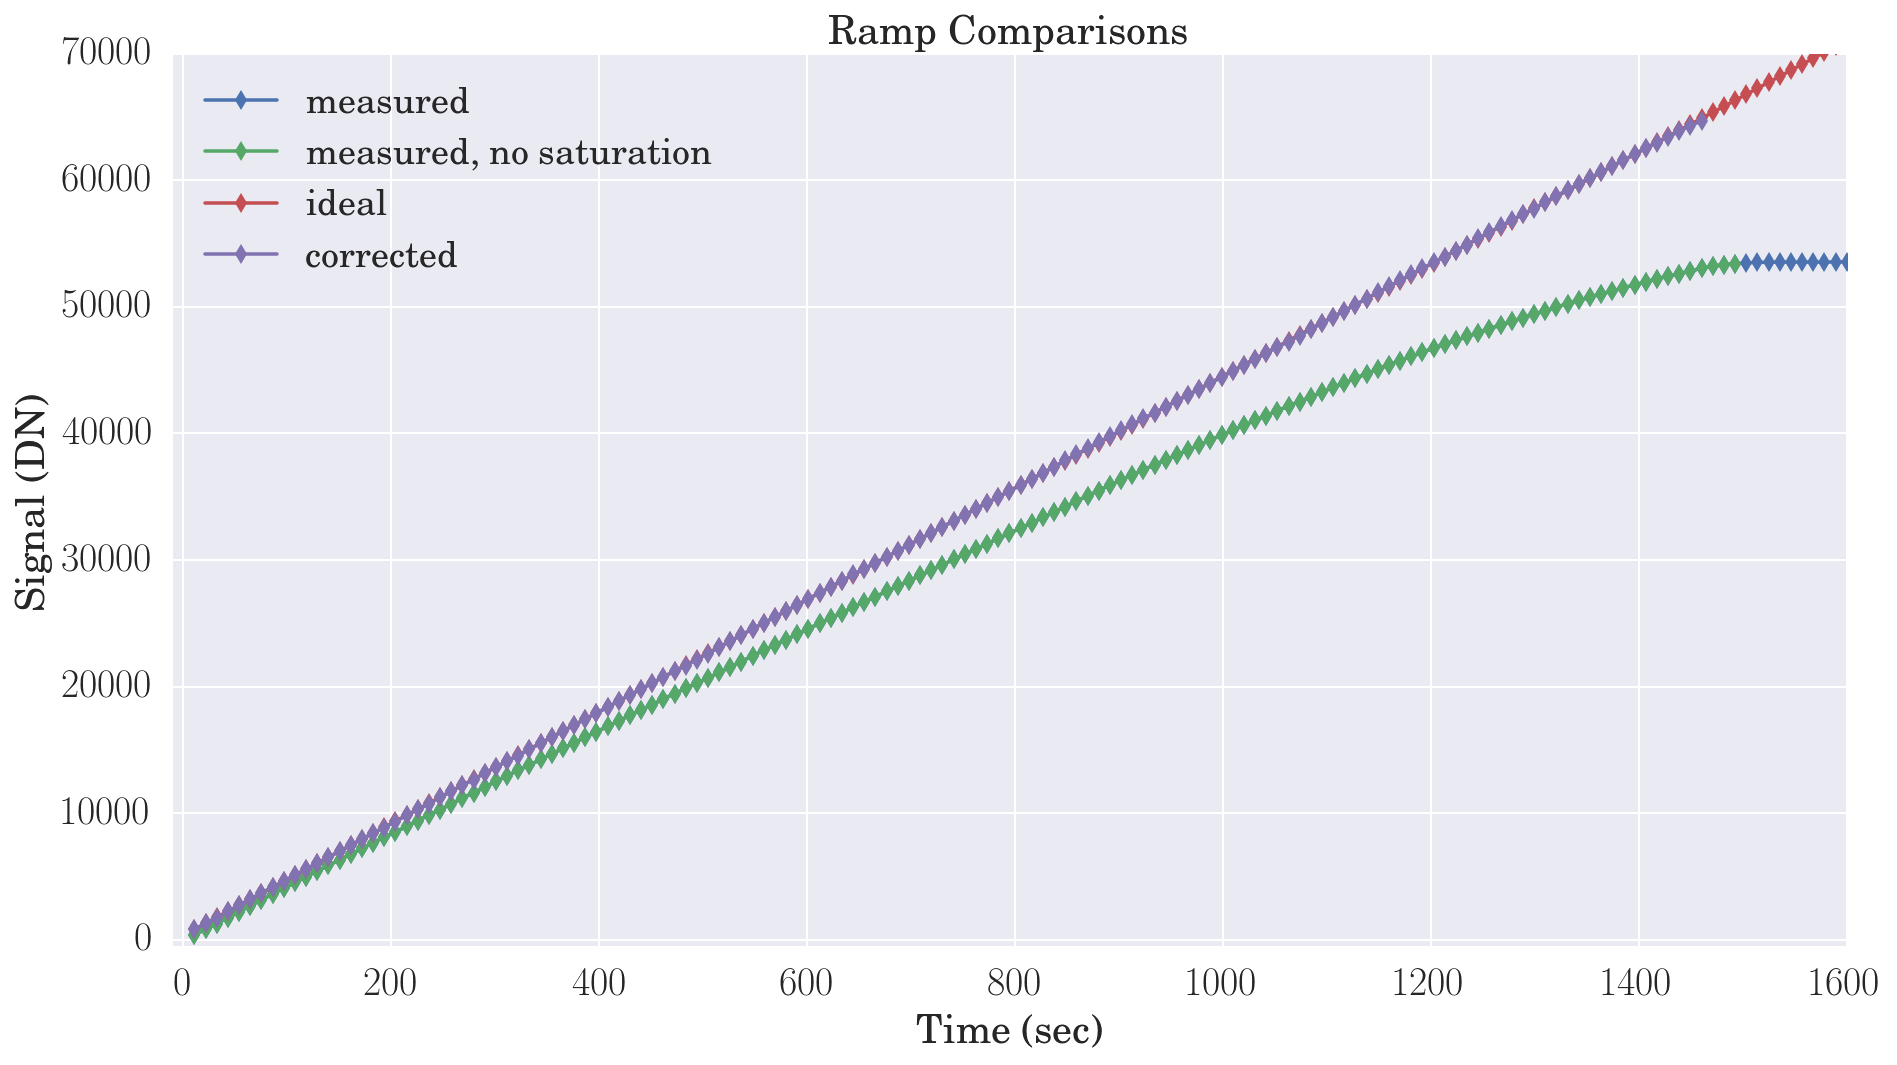

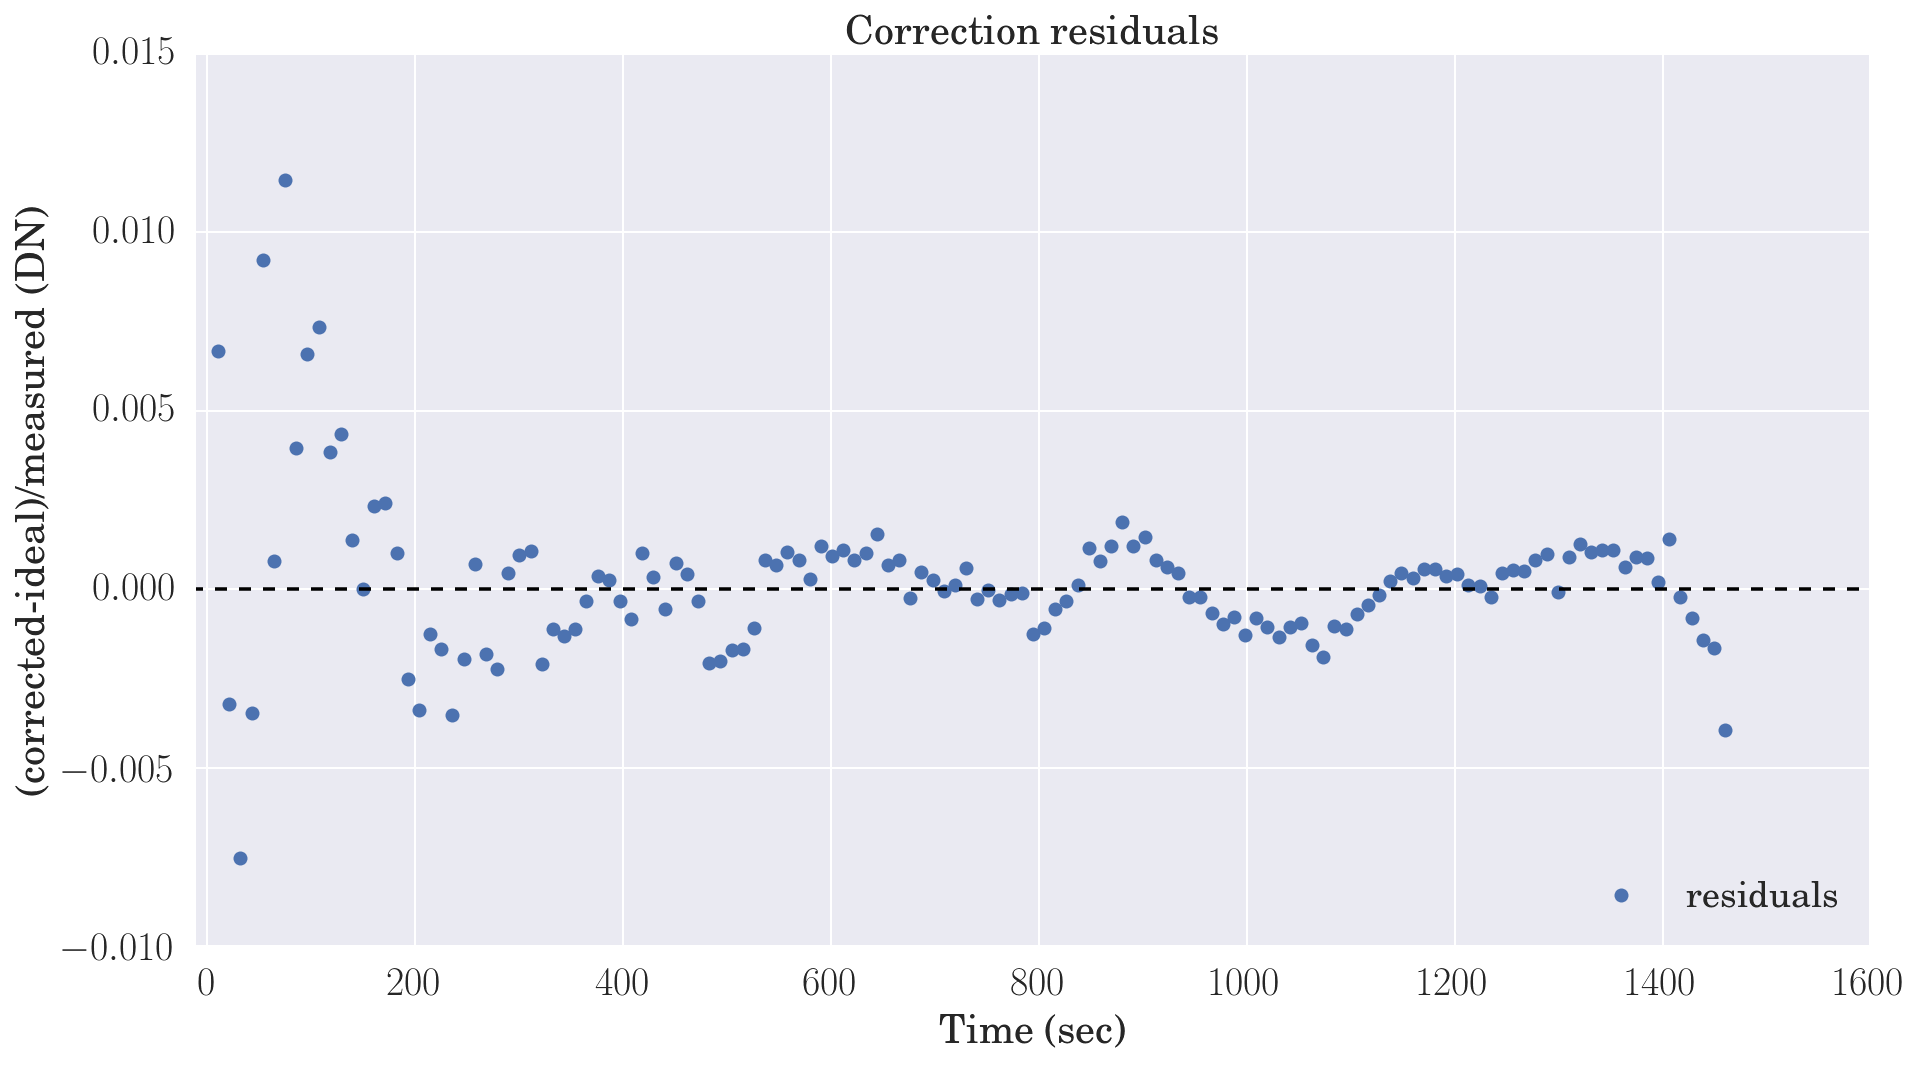

In [15]:
# Plot the ramps
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(frame*tgroup,signal,label='measured',marker='d')
ax.plot(nosat_ramp[0]*tgroup,nosat_ramp[1],label='measured, no saturation',marker='d')
ax.plot(frame*tgroup,intercept+new_ideal_rate*(frame*tgroup),marker='d',label='ideal')
ax.plot(nosat_ramp[0][:upperlimit]*tgroup,corrected_signal,marker='d',label='corrected')
ax.set_title('Ramp Comparisons')
ax.set_xlabel('Time (sec)')
ax.set_xlim(-10,1600)
ax.set_ylim(-500,70000)
ax.set_ylabel('Signal (DN)')
ax.legend(loc='best',prop={'size':18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)  
    
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(nosat_ramp[0][:upperlimit]*tgroup, correction_resid, linestyle='none',marker='o',label='residuals')
ax.axhline(y=0,xmin=-1000,xmax=3000,linestyle='dashed',color='black')
ax.set_title('Correction residuals')
ax.set_xlabel('Time (sec)')
ax.set_xlim(-10,1600)
# ax.set_ylim(-500,70000)
ax.set_ylabel('(corrected-ideal)/measured (DN)')
ax.legend(loc=4,prop={'size':18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20) 
    
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(nosat_ramp[0][:upperlimit]*tgroup,corrected_signal)    
    
print('Ideal slope:',new_ideal_rate)    
print('Corrected slope',slope)

## ** NOTE **
# matplotlib is being weird -- if the corrected ramp seems really offset from the ideal ramp, just 
# rerun this cell. Not sure why that is happening.

In [12]:
#forward_coeffs = np.array([0.,1.,7.30407763e-06,-1.81108032e-10,  -2.56823269e-15,   2.06622793e-19, -2.32379805e-24])
#inv_coeffs = np.array([0.,1.,   -7.20183671e-06,2.20004617e-10,  -1.19325879e-16,  -1.34411786e-19,1.69498597e-24])

In [4]:
print(coeffs_arr)
print(coeffs_arr_inverse)

[  0.00000000e+00   1.00000000e+00   2.12711252e-06  -1.26122274e-10
   9.86962244e-15  -2.92579934e-19   3.01823210e-24]
[  0.00000000e+00   1.00000000e+00  -1.86715031e-06   7.68895196e-11
  -6.42398627e-15   1.99648144e-19  -2.13109981e-24]


In [4]:
def apply(test_sig,beta):
    return beta[0] + test_sig * (beta[1] + test_sig * 
                                 (beta[2]+ test_sig * (beta[3] + test_sig * (beta[4] + test_sig * 
                                                                             (beta[5] + test_sig * beta[6])))))
def apply2(s,c):
    return c[0] + c[1]*s + c[2]*s**2 + c[3]*s**3 + c[4]*s**4 + c[5]*s**5 + c[6]*s**6

def apply_inverse(test_sig,beta):
    return test_sig / (1 + test_sig * (beta[0]
                                          + test_sig * (beta[1]
                                          + test_sig * (beta[2]
                                          + test_sig * (beta[3]
                                          + test_sig * beta[4])))))

In [9]:
inputsig = 10000.
corrected = apply2(inputsig,coeffs_arr)
uncorrected = apply2(corrected,coeffs_arr_inverse)
#uncorr2 = apply_inverse(corrected,coeffs_arr[2:])
print(inputsig,corrected,uncorrected)#,uncorr2)

(10000.0, 10159.045441374767, 10003.203795180558)


In [44]:
#def apply2(indata,cof):
#    return indata * (1 + indata * (cof[0] + indata * (cof[1] + indata * (cof[2] + indata 
#                                                                                   * (cof[3] + indata * cof[4])))))

In [10]:
inputsig = 50000.
corrected = apply(inputsig,coeffs_arr)
uncorrected = apply(corrected,coeffs_arr_inverse)
print(inputsig,corrected,uncorrected)

(50000.0, 56966.284523452203, 50005.759637370087)


In [56]:
#corrected_signal_inv is from the original data with the inverse coeffs applied, so it's not correct to compare
#f,a = plt.subplots(figsize=(15,8))
#a.plot(nosat_ramp[0]*tgroup,nosat_ramp[1],color='black',marker='8',label='orig')
#a.plot(nosat_ramp[0][1:upperlimit+1]*tgroup,corrected_signal,color='blue',marker='8',label='linearized')
#a.plot(nosat_ramp[0][1:upperlimit+1]*tgroup,corrected_signal_inv,color='red',marker='8',label='unlinearized')
#a.legend(loc='best')
#a.set_xlim(0,100)
#a.set_ylim(0,1000)
#plt.show()

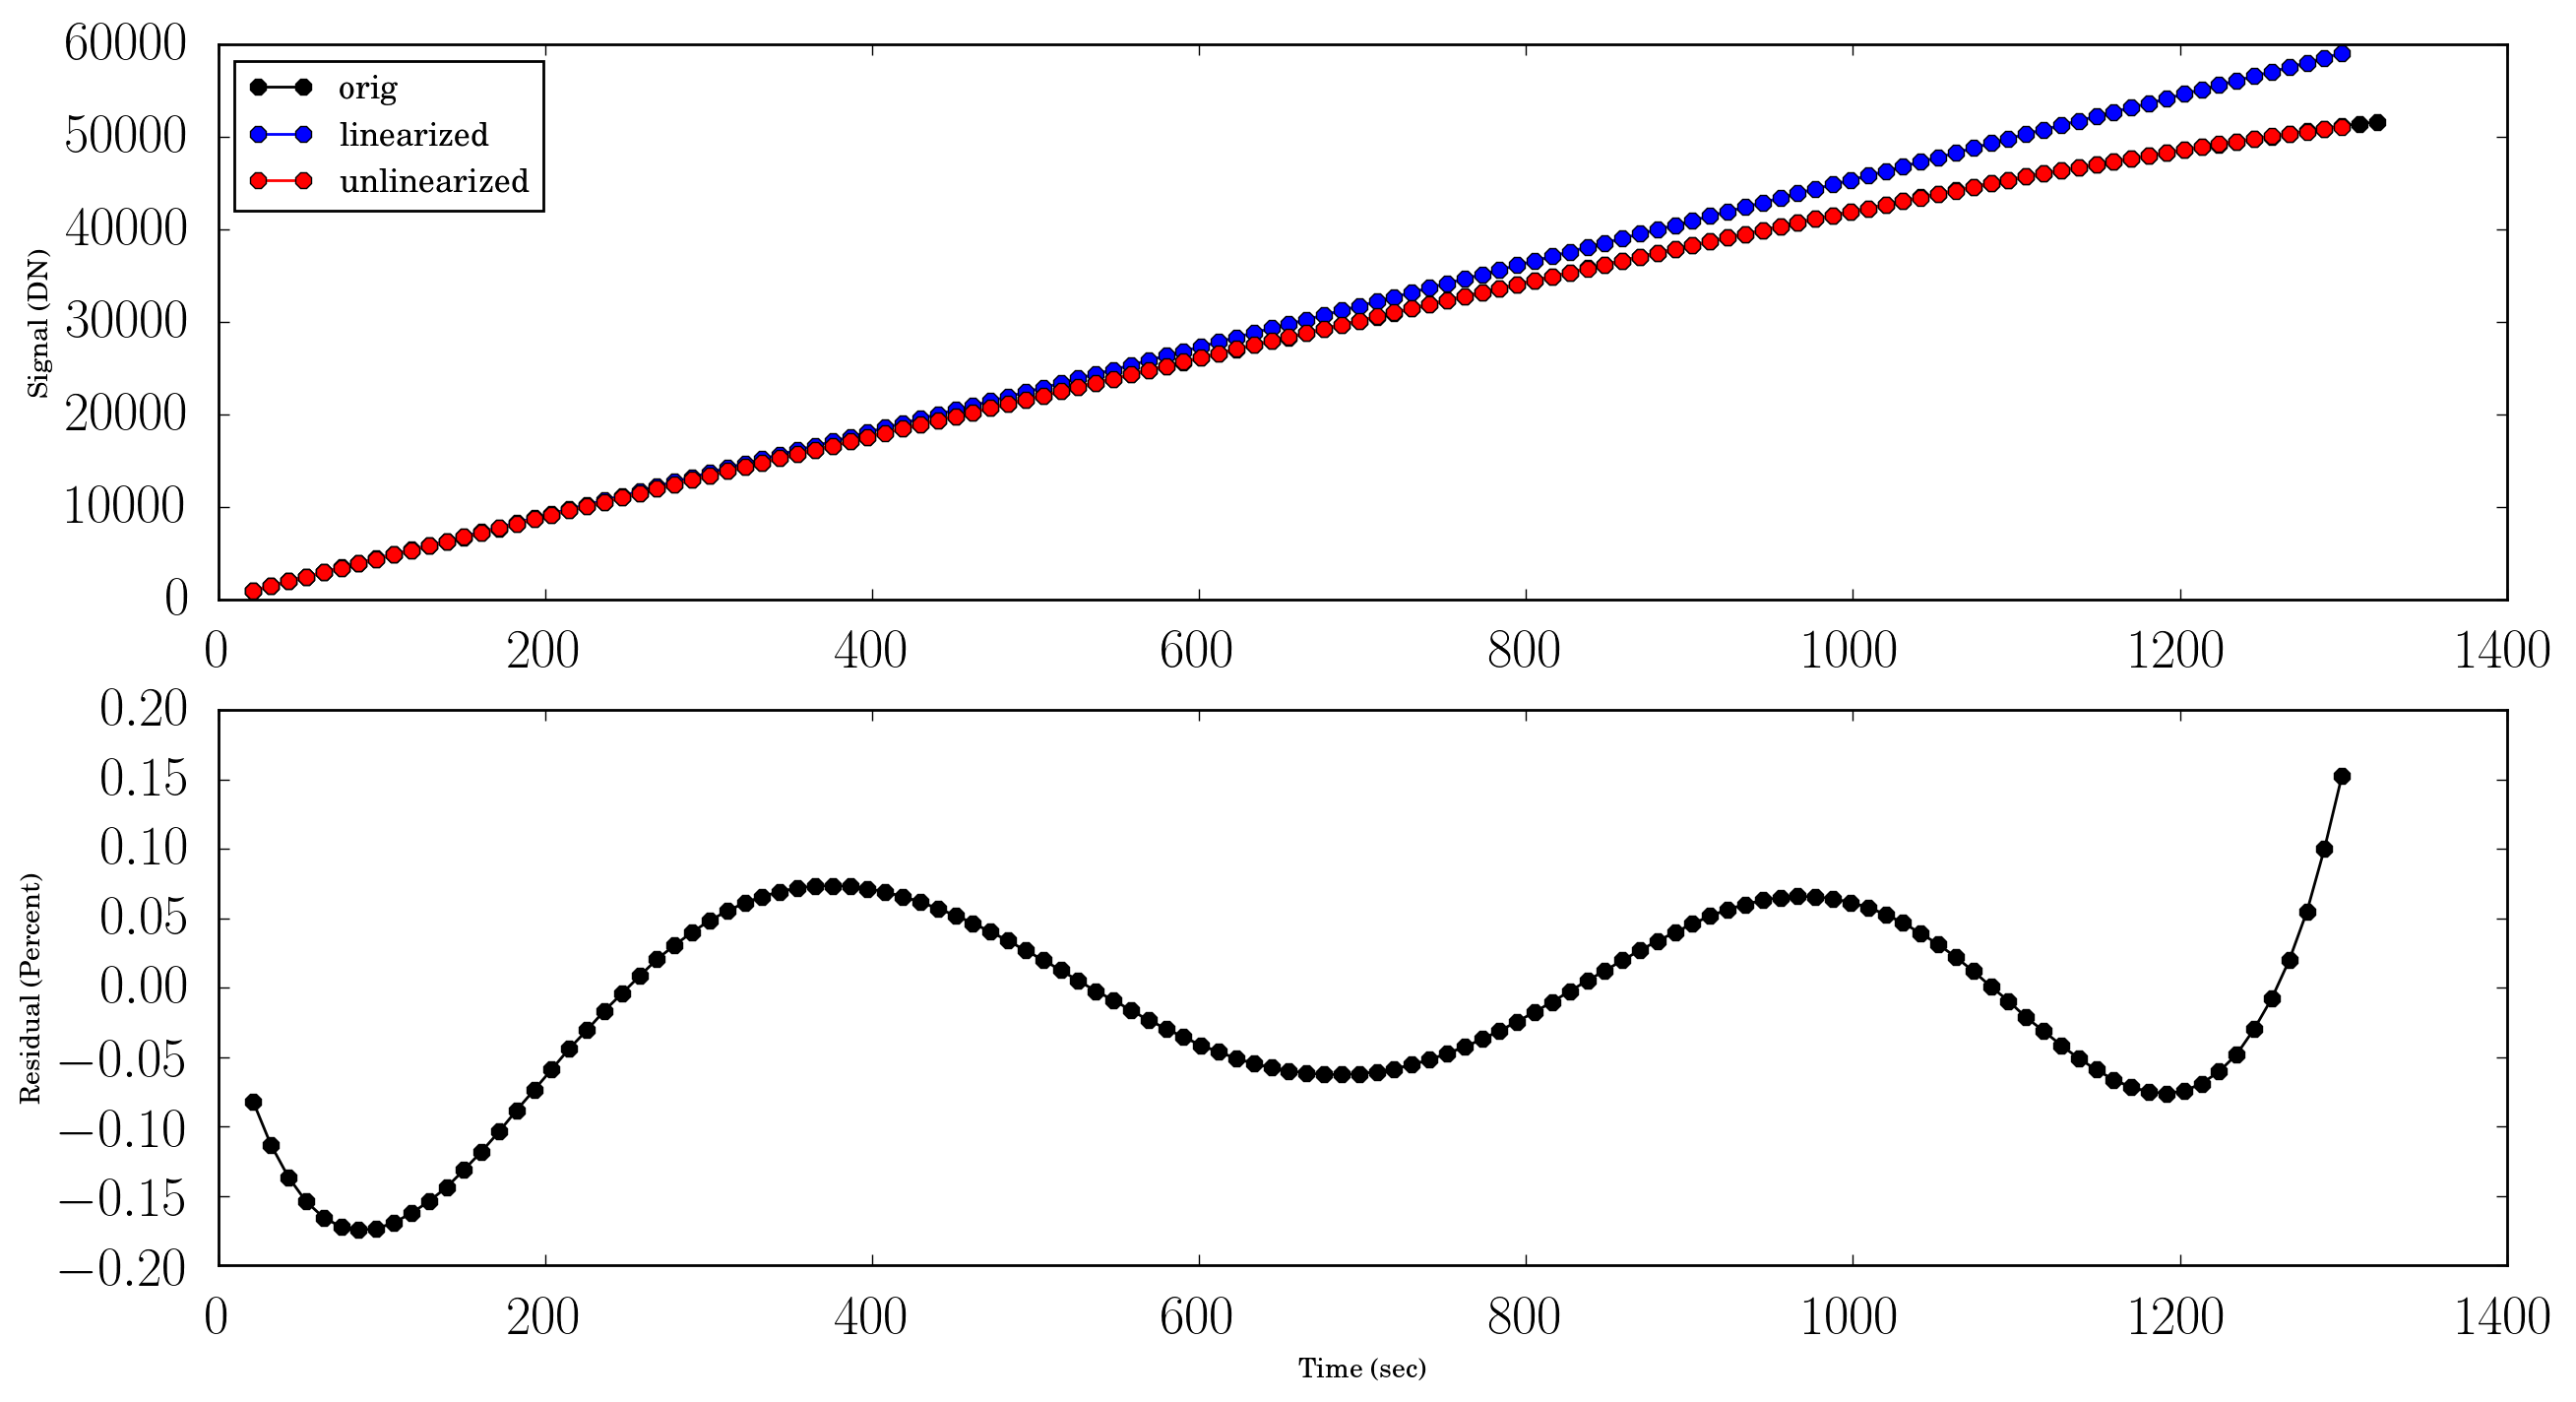

In [20]:
check = coeffs_arr * -1
check[1]=1.
f,(a,b) = plt.subplots(2,figsize=(15,8))
a.plot(nosat_ramp[0][1:]*tgroup,nosat_ramp[1][1:],color='black',marker='8',label='orig')
a.plot(nosat_ramp[0][1:upperlimit+1]*tgroup,corrected_signal,color='blue',marker='8',label='linearized')
uncorrected = apply2(corrected_signal,coeffs_arr_inverse)
#uncorrected = apply_inverse(corrected_signal,coeffs_arr[2:])
a.plot(nosat_ramp[0][1:upperlimit+1]*tgroup,uncorrected,color='red',marker='8',label='unlinearized')
a.legend(loc='best')
a.set_ylabel('Signal (DN)')
#a.set_xlim(0,100)
#a.set_ylim(0,1000)
b.plot(nosat_ramp[0][1:-2]*tgroup,100.*(nosat_ramp[1][1:-2]-uncorrected)/nosat_ramp[1][1:-2],color='black',marker='8',label='Residuals (%)')
b.set_xlabel('Time (sec)')
b.set_ylabel('Residual (Percent)')
plt.show()

In [14]:
check

array([ -0.00000000e+00,   1.00000000e+00,  -2.21461298e-06,
         1.41581511e-10,  -1.07767684e-14,   3.14207126e-19,
        -3.19866491e-24])

In [15]:
coeffs_arr

array([  0.00000000e+00,   1.00000000e+00,   2.21461298e-06,
        -1.41581511e-10,   1.07767684e-14,  -3.14207126e-19,
         3.19866491e-24])

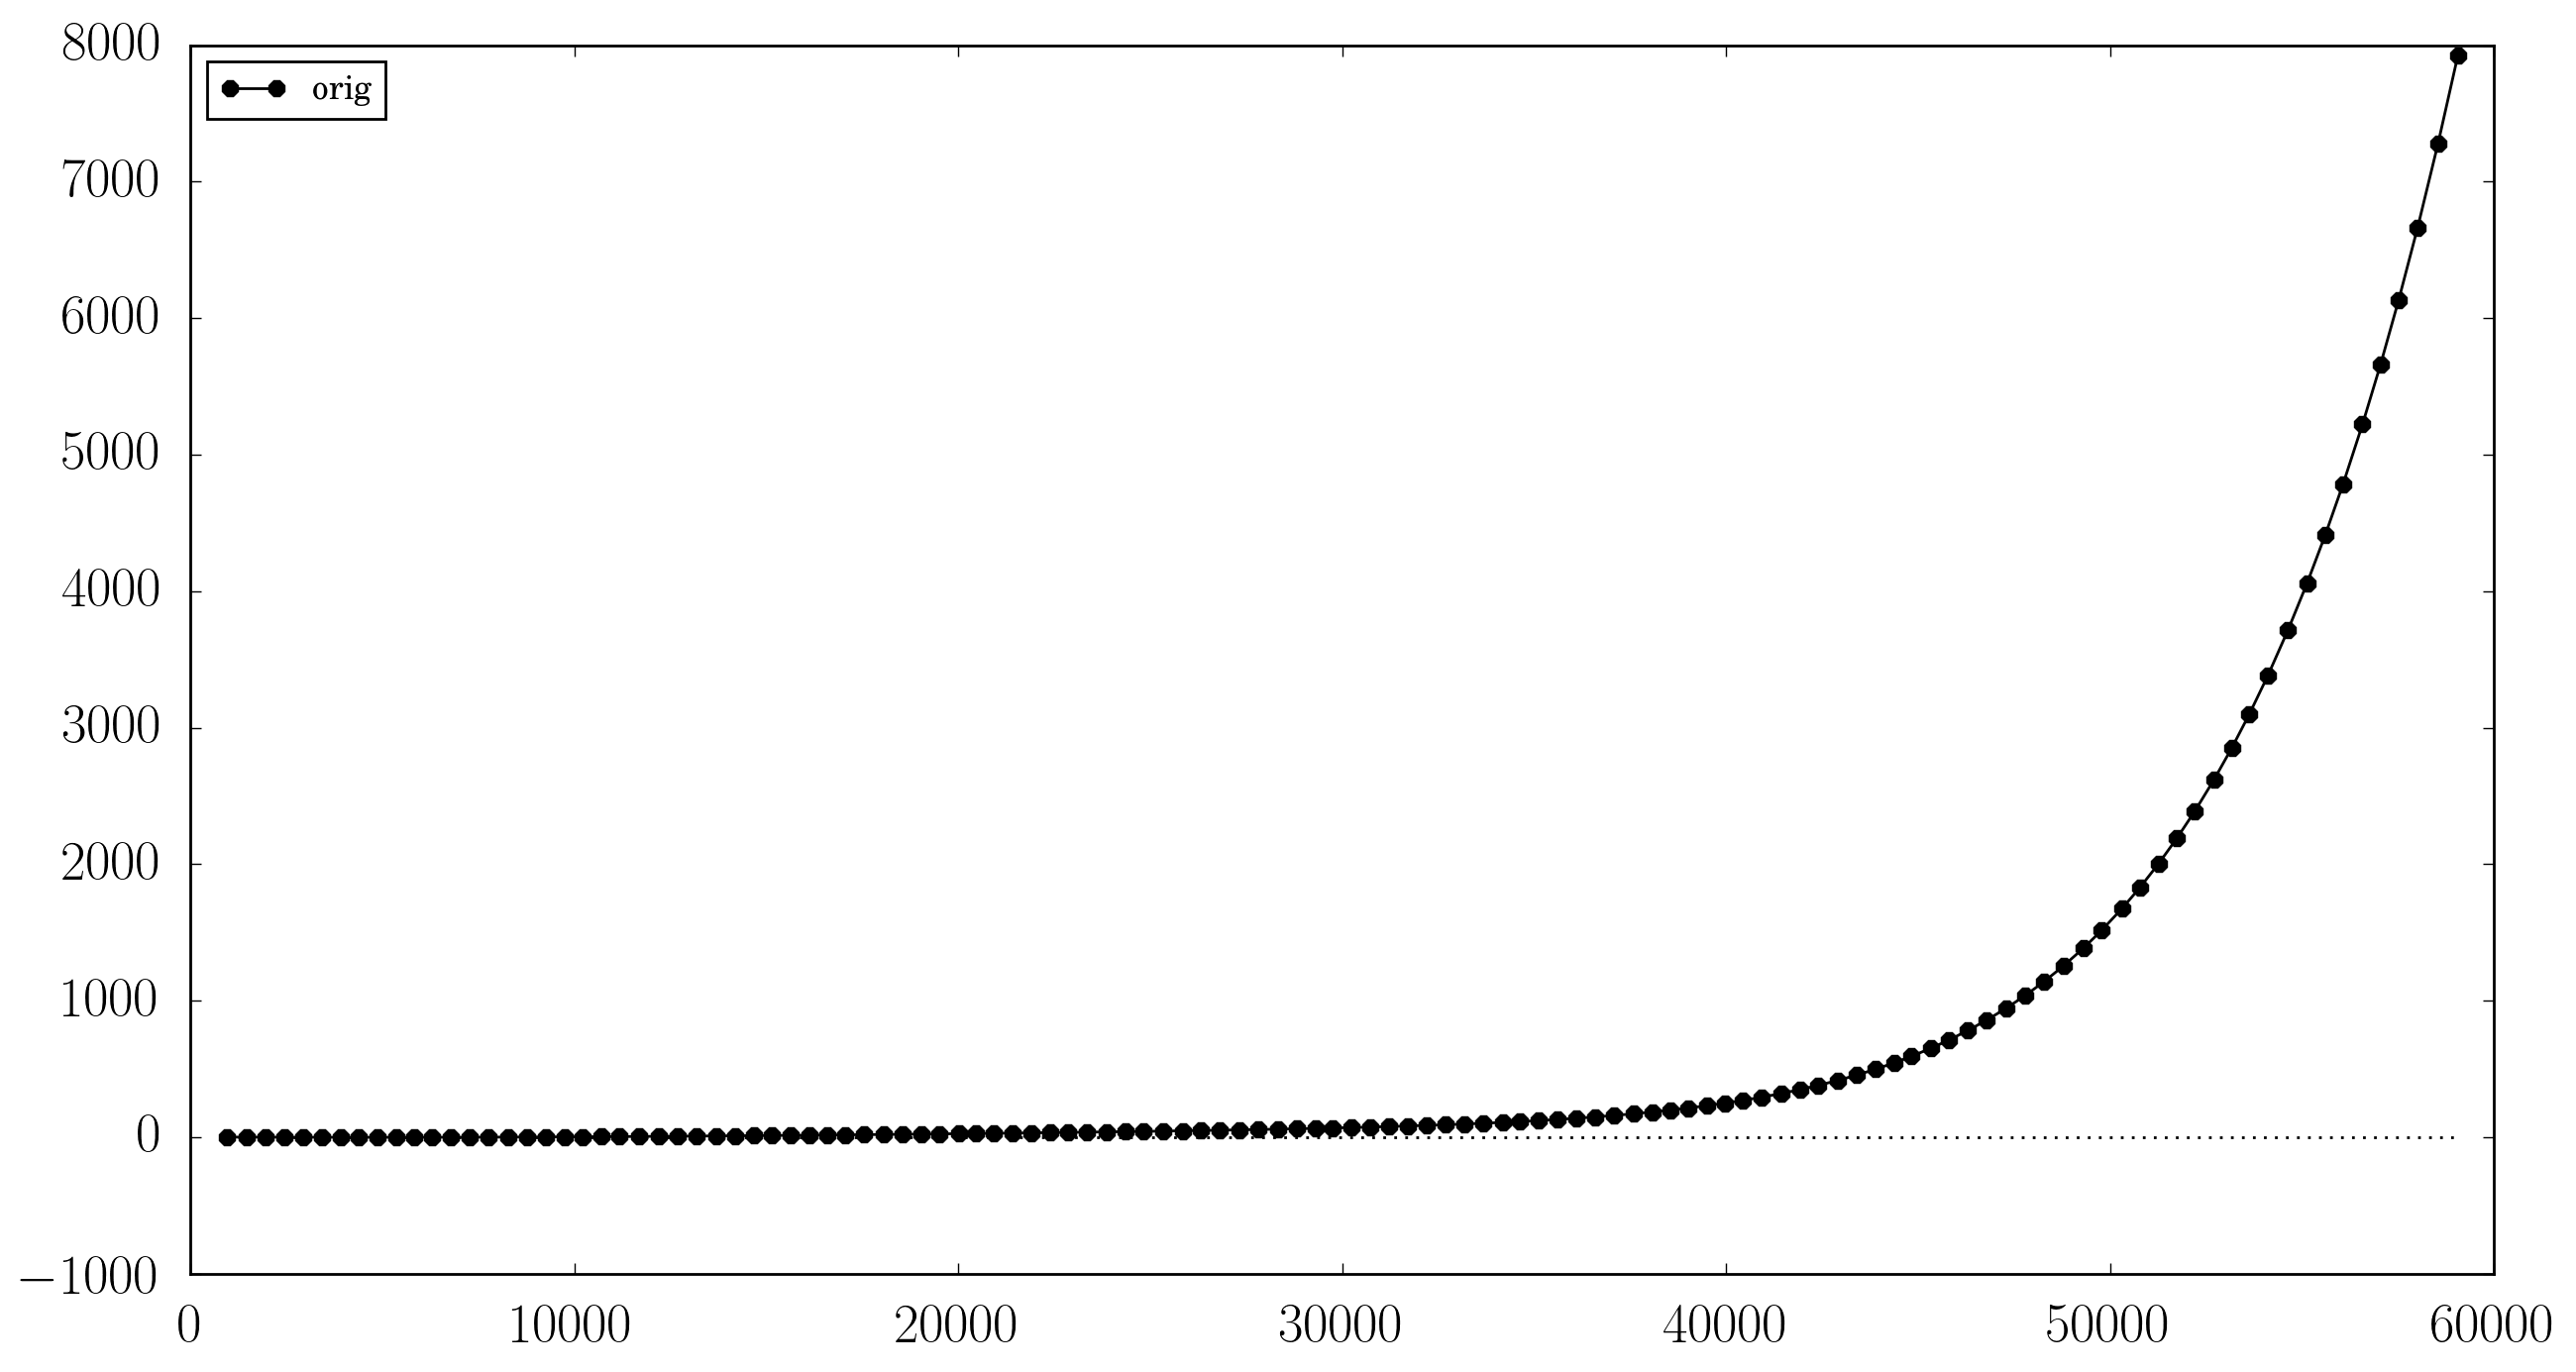

In [94]:
f,a = plt.subplots(figsize=(15,8))
a.plot(corrected_signal,np.zeros(len(corrected_signal)),linestyle=':',color='black')
a.plot(corrected_signal,(nosat_ramp[1][1:len(uncorrected)+1]-uncorrected),color='black',marker='8',label='orig')
#uncorrected = apply2(corrected_signal,coeffs_arr_inverse)
#a.plot(nosat_ramp[0][1:upperlimit+1]*tgroup,uncorrected,color='red',marker='8',label='unlinearized')
a.legend(loc='best')
#a.set_xlim(0,100)
#a.set_ylim(0,1000)
plt.show()

In [77]:
nosat_ramp[0][0:3]


array([1, 2, 3])

In [82]:
len(uncorrected)

128

In [85]:
print(len(nosat_ramp[0][1:len(uncorrected)+1]),len(nosat_ramp[1][1:]))

(128, 130)


In [98]:
signal[first_sat_grp]

51680.277

In [7]:
def save_coeffs(c,outfile):
    h0 = fits.PrimaryHDU()
    h1 = fits.ImageHDU(c)
    hlist = fits.HDUList([h0,h1])
    hlist.writeto(outfile,clobber=True)

In [4]:
inv_c = np.array([0.00000000e+00,1.00000000e+00,-1.86715031e-06,7.68895196e-11,-6.42398627e-15,1.99648144e-19,-2.13109981e-24])

In [5]:
inv_arr = np.zeros((7,2048,2048))
for i in range(4,2044):
    for j in range(4,2044):
        inv_arr[:,j,i] = inv_c

In [ ]:
save_coeffs(inv_arr,'test_inverse_linearity_coeffs_from_notebook.fits')

In [ ]:
#for full detector

#input_file = "../B3/NRCN815B-LIN-5365135655_7_488_SE_2015-12-31T18h07m58_uncal_dq_init_saturation_superbias_refpix.fits"
input_file = "NRCN815A-LIN-6015194727_8_481_SE_2016-01-15T20h41m35_uncal_dq_init_saturation_superbias_refpix.fits"

# Load the data
data, hdr, tgroup, ngroups, nskip, nframe = load_data(input_file)

# Get sigma_range for saturation
sigma_range = [20,60]  # for short-wave

# Get accuracy value for correction
accuracy = 0.003

# Get frame values frame values (RAPID for now)
frame = np.arange(nframe, ngroups+1, np.int(nframe+nskip))

# Other parameters for fitting
first_frame  = 1                          # 0 or 1: 0 to include first frame, 1 to exclude first frame
limit = 3                                 # Saturation = 0 +/- limit*sigma
poly_order = 5                            # ramp-fit polynomial order
corr_order = 5                            # correction polynomial order
pipeline_coefs = 2                        # number of coefficients to auto add for the pipeline (first_coeff + second+coeff = 2)
num_coefs = pipeline_coefs + poly_order   # total number of coefficients (corr_coefs + pipeline_coefs)
unc = 64.0                                # estimate: unc = 64.0 = 8.**2, for unc = np.sqrt(readnoise*gain + signal)
hard_limit = 2                            # number of groups to subtract from last unsaturated group to get better correction

# Initialize arrays to store values
slope_int_arr = np.zeros((2))
coeffs_arr = np.zeros((num_coefs))
coeffs_arr_inverse = np.zeros((num_coefs))
dq_arr = np.zeros((1))
sat_arr = np.zeros((4))
mask_arr = np.zeros(np.shape(coeffs_arr), dtype='bool')

# Choose a pixel to look at
pixel = [750, 600]
pixel = [400,400]

final_coeffs = np.zeros((7,2048,2048))
final_coeffs_inv = np.zeros((7,2048,2048))
for x in range(4,2044):
    for y in range(4,2044):
        pixel = [x,y]
        
        if ((x % 100 == 0) & (y % 100 == 0)):
            print('Pixel ({},{})'.format(x,y))

        # Get signal values for each pixel.
        signal = data[0,:,pixel[1],pixel[0]]

        # Catch warnings to flag them in the dq_array.
        with warnings.catch_warnings():
            warnings.simplefilter("error", OptimizeWarning)
            warnings.simplefilter("error", RuntimeWarning)
            try:

                # Get hard saturation and ramp with no saturated frames.
                hard_sat, first_sat_grp = \
                    get_saturation(signal, sigma_range, limit)
                nosat_ramp = [frame[:first_sat_grp],
                              signal[:first_sat_grp]]

                # Fit the ramp below hard saturation.
                new_ramp, new_ideal_rate, intercept, nonlin, \
                        nonlin_unc, inverse_nonlin = \
                    ramp_fit(pixel, first_frame, tgroup, nosat_ramp,
                                 poly_order, unc)
                slope_int_arr[0] = new_ideal_rate
                slope_int_arr[1] = intercept     

                # Do the non-linearity correction and get coefficients.
                beta_inv, correction_resid_std_inv, soft_inv, upperlimit_inv, corrected_signal_inv, correction_resid_inv = \
                    correct_signal_short(new_ramp, inverse_nonlin, nonlin_unc, 
                                         intercept, new_ideal_rate, first_sat_grp, 
                                         signal, tgroup, corr_order, hard_limit,inverse=True)
            
                beta, correction_resid_std, soft, upperlimit, corrected_signal, correction_resid = \
                    correct_signal_short(new_ramp, nonlin, nonlin_unc, 
                                         intercept, new_ideal_rate, first_sat_grp, 
                                         signal, tgroup, corr_order, hard_limit,inverse=False)    

                # Save all correction coefficients.
                coeffs_arr[0] = 0.0
                coeffs_arr[1] = 1.0
                coeffs_arr[2:] = beta[:]        
                
                coeffs_arr_inverse[0] = 0.0
                coeffs_arr_inverse[1] = 1.0
                coeffs_arr_inverse[2:] = beta_inv[:]        
                
        
                # Find highly non-linear ramps, flag them in DQ array.
                #if correction_resid_std > 0.005:
                #    dq_arr[pixel[1],pixel[0]] = np.uint8(2)
                #    mask_arr[:] = True

                # Load results for saturation into separate array.
                sat_arr[0] = hard_sat
                sat_arr[1] = soft
                sat_arr[2] = upperlimit
                sat_arr[3] = correction_resid_std

                # Create a mask to use for averaging later that blocks
                # out pixels for which soft saturation could not be
                # determined (weird ramps, possibly). Update DQ array.
                if np.isnan(soft) == True:
                    mask_arr[:] = True
                    dq_arr[0] = np.uint8(4)

                final_coeffs[:,y,x] = coeffs_arr
                final_coeffs_inv[:,y,x] = coeffs_arr_inverse
                    
            # Flag pixels fitting or correction problems.
            except (RuntimeError, ValueError, OptimizeWarning,
                    TypeError, RuntimeWarning):
                dq_arr[0] = np.uint8(4)
                mask_arr[:] = True
                coeffs_arr[:] = np.nan
                
save_coeffs(final_coeffs_inv,'test_inverse_linearity_coeffs_from_notebook.fits')